Бизнес давольно часто интересует как у них обстоят дела и для того, чтобы держать руку на пульсе бизнес считает давольно много метрик о своих пользователях. и о том, что происходит в данный момент с их выручкой, с их возвращаемостью и т.д.

Для того, чтобы понять насколько хороша конкретная точка, подсчитаная в конкретный момент времени для нее имеет смысл построить доверительный интервал и посмотреть в каком диапазоне она бы могла колебаться, в зависимости от выборки пользователей

С помощью пользовательских метрик можно проверять различные гипотезы и различные улучшения, которые можно было бы пытаться применить на практике. Например если есть магазины, можно бы было поставить стенд рядом, который мы ожидаем, что пользователи и покупатели используют одновременно, а в других магазинах оставить все как есть и посмотреть, приведет ли это к увелечению прибыли (правда ли, что 0 не попадает в доверительный интервал при разности средних)

Данные процедуры называются A/B тестами

## Продуктовые метрики

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


Возвращаемость (retention), средняя выручка (revenue per user, RPU)

In [2]:
visits = pd.read_csv('marketing_log.csv', sep='\t')

C:\Users\Pavel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-09-02,1131660440785968503,Chrome,desktop,NaN
1,2016-09-02,377306020877927890,Firefox,desktop,NaN
2,2016-09-02,3895546263509774583,Chrome,desktop,NaN
3,2016-09-02,4763447161404445595,UC Browser,desktop,NaN
4,2016-09-02,27294437909732085,Chrome,mobile,NaN


In [4]:
visits['date'] = pd.to_datetime(visits['date'], format = '%Y-%m-%d')

In [5]:
visits.sort_values('date', inplace = True)

In [6]:
visits.reset_index(drop=True, inplace = True)

In [7]:
visits.shape

(177973, 5)

In [8]:
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-08-05,377595677869445136,Chrome,desktop,NaN
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN


## Число пользователей

Сколько людей пользуются в день, неделю, месяц

In [9]:
day = visits.groupby('date').agg({'fullVisitorId' : 'nunique'})

In [10]:
day.head() #дата, уникальное кол-во пользователей

,fullVisitorId
date,
2016-08-05,2492
2016-08-11,2446
2016-08-16,2619
2016-08-20,1555
2016-08-22,2352


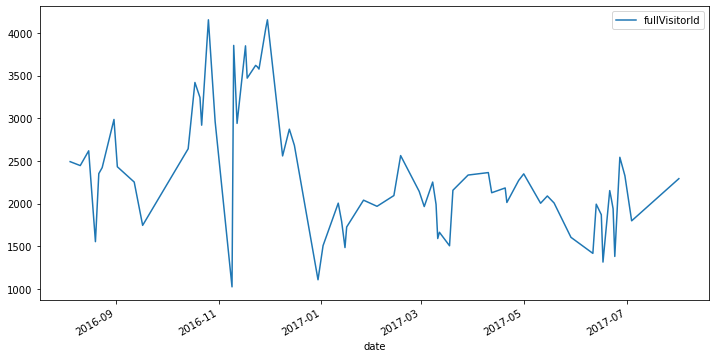

In [11]:
day.sort_index().plot(figsize=(12,6));

## Возвращаемость
(retention)

Обычно считается на какой-то день, если интересует возвращаемость на первый день, то это означает, что человек вернулся полсе первого дня с момента посещения. (на след день)

7ого дня - на 8ой день
если человек вернулся на сайт на 10ый день, он попадет как в retention1, так и в retention7. Так как он вернулся после 1го дня и после 7го дня

Дата первого появления пользователя

In [12]:
first_visit = visits.groupby('fullVisitorId').agg({'date':'min'}) # для каждого юзера минимальную дату
first_visit.columns = ['firstVisit'] # отдельная колонка 

visits = visits.join(first_visit, on='fullVisitorId') 

In [24]:
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,firstVisit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05


In [15]:
visits['daysFromFirstVisit'] = (visits.date - visits.firstVisit).apply(lambda w: w.days)

<AxesSubplot:>

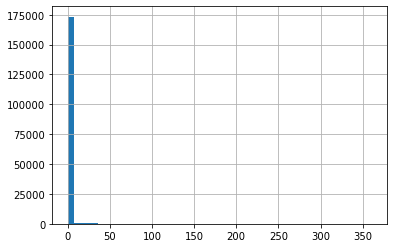

In [16]:
visits['daysFromFirstVisit'].hist(bins=50)

<AxesSubplot:>

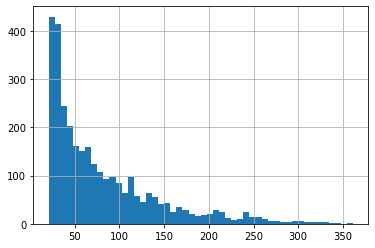

In [17]:
visits[visits['daysFromFirstVisit'] > 20]['daysFromFirstVisit'].hist(bins=50)

сколько дней прошло с текущего визита, до максимального

In [19]:
firstVisit = visits.groupby(['firstVisit', 'fullVisitorId']).agg({'daysFromFirstVisit': 'max'}).reset_index()

In [22]:
firstVisit.head()

,firstVisit,fullVisitorId,daysFromFirstVisit
0,2016-08-05,1000971553963693366,0
1,2016-08-05,1006834109386002658,0
2,2016-08-05,101246539776970727,0
3,2016-08-05,1013171119747358712,0
4,2016-08-05,1015220001673280213,0


Посчитать retention7, если daysFromFirstVisit оказывается больше 7, значит человек  вернулся более, через 7 дней после первого посещения. Таки люди наиболее интересны. Найти кол-во

In [25]:
retention = (
    firstVisit.groupby('firstVisit')['daysFromFirstVisit']
    .agg([ # больше 1 => вернулся хотябы через день
        ("success", lambda w: sum(w >= 7)),
        ("total", "count") # сколько всего людей зашли в эту дату
    ])
)


In [26]:
retention.head()

,success,total
firstVisit,,
2016-08-05,108,2492
2016-08-11,103,2413
2016-08-16,102,2543
2016-08-20,35,1532
2016-08-22,92,2234


## Средний доход с пользователа (RPU)

как часто люди покупают

In [29]:
100*(1 - visits['transactionRevenue'].isnull().sum()/visits.shape[0]) #процент покупок

1.3091873486427708

люди которые что-то покупали

In [40]:
visits[visits['transactionRevenue'].isnull()]

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,firstVisit,daysFromFirstVisit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05,0
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05,0
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05,0
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05,0
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05,0
...,...,...,...,...,...,...,...
177968,2017-08-01,4841594360292833266,Safari,desktop,NaN,2017-08-01,0
177969,2017-08-01,4560356787162228889,Safari,mobile,NaN,2017-08-01,0
177970,2017-08-01,1733308980612977236,Chrome,desktop,NaN,2017-08-01,0
177971,2017-08-01,7461007246247623723,Safari,mobile,NaN,2017-08-01,0


In [41]:
# RPU на месячной основе
visits['month'] = visits['date'].apply(lambda w: w.strftime('%Y-%m'))

purchases = visits.dropna(subset = ['transactionRevenue'])


In [42]:
purchases.shape

(2330, 8)

<AxesSubplot:>

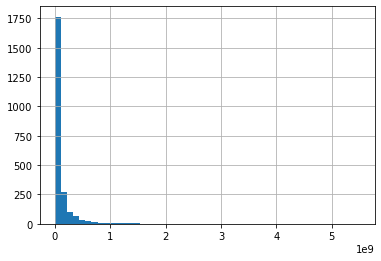

In [43]:
purchases['transactionRevenue'].hist(bins = 50)

слишком большой хвост

In [44]:
quantile_99 = purchases['transactionRevenue'].quantile(0.99)

In [45]:
quantile_99

1194364900.0000002

In [46]:
purchases = purchases[purchases['transactionRevenue'] < quantile_99]

<AxesSubplot:>

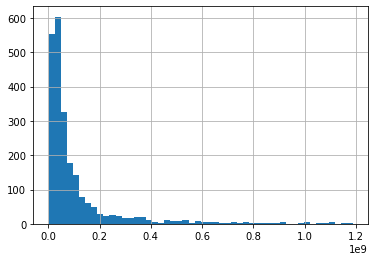

In [47]:

purchases['transactionRevenue'].hist(bins=50)

Среднее, стандартное отклонение, число наблюдений каждого месяца

In [51]:
datePurchases = (
    visits.groupby(['month'])['transactionRevenue']
    .agg([('rpu', 'mean'),
          ('count', 'count'),
          ('se', 'std')])
    .reset_index()
)

In [52]:
datePurchases.head()

,month,rpu,count,se
0,2016-08,1.403108e+08,302,2.576639e+08
1,2016-09,1.596071e+08,63,2.466225e+08
2,2016-10,1.495286e+08,154,2.847047e+08
3,2016-11,1.582393e+08,298,3.637715e+08
4,2016-12,1.078180e+08,249,2.386044e+08
